In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

# Task 1: Cross-Validation with Ridge Regression

You are given data from the following function:
$f(x) = - 0.1x^3 + x^2 - 0.1x + 1 $.

However, your data set is highly noisy, and unfortunately also seems to be quite unbalanced and small.

In this exercise your task is to apply ridge regression to approximate the data distribution. In ridge regression the regularization term term $\alpha \sum_{j=1}^p \beta_j^2$ is added to the error function.
The main goal of this task is to optimize the hyperparameter $\alpha$ using k-fold cross validation.

First we load the data. You do not have to change anything here.

In [ ]:
def f(X, noisy=False):
  y = np.zeros(X.shape)
  param = [1, -.1, 1, -.1]
  for i, weight in enumerate(param):
    y += weight * X**(i)

  # Adding noise
  if noisy:
    y += np.random.normal(0, 1, X.shape)
  return y

(229,)


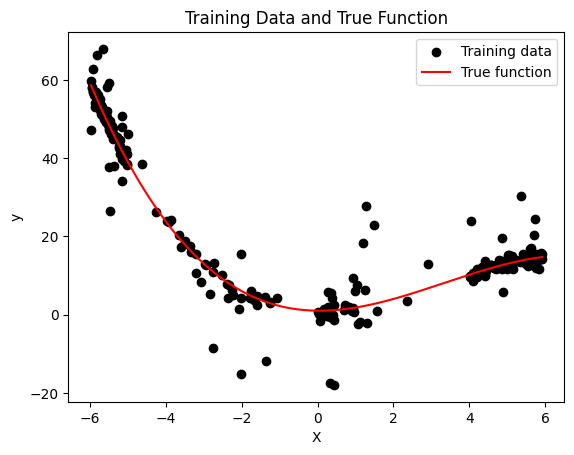

In [ ]:
# Number of data points
np.random.seed(2)
data_points = 150
n_outliers = 50

# Generating synthetic data
X = np.concatenate((np.random.uniform(-6, -5, int(data_points/2)),
                    np.random.uniform(-5, -4, 2),
                    np.random.uniform(-4, -1, int(data_points/4)),
                    np.random.uniform(0, 1.5, int(data_points/4)),
                    np.random.uniform(1.5, 3.9, 3),
                    np.random.uniform(4, 6, int(data_points/2))))
print(X.shape)
np.random.shuffle(X)
y = f(X, noisy=True)

X = X[:, np.newaxis]

X_holdout = np.random.uniform(-6, 6, 100)[:, np.newaxis]
y_holdout = f(X_holdout, noisy=True)

# Introduce outliers
outlier_indices = np.random.choice(data_points, n_outliers, replace=False)
outlier_indices = np.concatenate((outlier_indices, np.where(np.logical_and(X < 4, X > 1))[0], np.where(np.logical_and(X > -5, X < -4))[0]))
y[outlier_indices] += np.random.normal(0, 10, outlier_indices.shape[0])

# number of weights to fit in regression
#degree = 10
degree = 20
poly_features = PolynomialFeatures(degree=degree, include_bias=True)

# number of folds
num_folds = 5

# plot data
# Generate a dense set of X values for smooth plotting
X_dense = np.linspace(X.min(), X.max(), 500)[:, np.newaxis]
y_dense = f(X_dense)

plt.figure()
plt.scatter(X, y, color='black', label='Training data')
#plt.scatter(X_holdout, y_holdout, color='blue', alpha=0.4, label='Holdout data')
plt.plot(X_dense, y_dense, color='red', label='True function')
plt.legend()
plt.title('Training Data and True Function')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [ ]:
def test_alphas(cross_validation=True, verbose=False):
  """
  Tests out a range of values for alphas for ridge regression
  @param cross_validation: Whether to use cross validation or one test and one train split
  @return: alphas, losses, best_alpha, best_loss
  """
  np.random.seed(1)
  num_alphas = 200
  alphas = np.logspace(-5, 4, num_alphas)

  min_loss = np.inf
  best_alpha = None

  losses = []

  for i in range(num_alphas):
    #alpha_log = -5 + i * 0.1
    #alpha = 10 ** alpha_log
    #alphas.append(alpha)
    alpha = alphas[i]

    # initialize model with current alpha
    model = make_pipeline(poly_features, Ridge(alpha, solver='svd'))

    if cross_validation:
      # do k-fold cross validation of model
      score = k_fold_cross_validation(X, y, num_folds, model)
    else:
      # do validation
      score = train_test_split_validation(X, y, model)

    if verbose:
      print(f"alpha: {alpha}, mse loss: {score}")
    losses.append(score)

    # store best alpha
    if score < min_loss:
      min_loss = score
      best_alpha = alpha

  print("-------------------------------------------------------------------------------------")
  print(f"Best alpha = {best_alpha} (log(alpha) = {np.log10(best_alpha)}), mse loss {min_loss}")

  return alphas, losses, best_alpha, min_loss


a) Complete the function, implementing the k-fold cross validation on the data-set (X, y), given the model we want to train. You are free to implement the ridge regression yourself. However, as our main goal is to implement cross-validation and not ridge regression, you can also use the class `sklearn.linear_model.Ridge`. For score we will use the mean squared error. You can implement this by yourself of use the function `mean_squared_error` from scikit learn.

In [ ]:
def k_fold_cross_validation(X, y, k, model):
  """
  Performs k-fold cross validation on the model
  @param X: Data x-values
  @param y: Data true Labels
  @param k: Number of folds
  @param model: Model to train
  @return: Mean and standard deviation of the mse scores from the k validations
  """
  # TODO: implement k-fold cross validation

  # TODO: get number of folds and do training and testing on each fold
  fold_size = len(X) // k
  indices = np.arange(len(X))
  #np.random.shuffle(indices)

  scores = []

  for i in range(k):
      test_indices = indices[i * fold_size:(i + 1) * fold_size]
      train_indices = np.concatenate((indices[:i * fold_size], indices[(i + 1) * fold_size:]))

      X_train, X_test = X[train_indices], X[test_indices]
      y_train, y_test = y[train_indices], y[test_indices]

      model.fit(X_train, y_train)

      y_pred = model.predict(X_test)
      score = mean_squared_error(y_pred, y_test)

      scores.append(score)

  return np.mean(scores)

- use this cell to test your implementation

alpha: 1e-05, mse loss: 31.153099760878085
alpha: 1.1097524964120721e-05, mse loss: 31.15309935126117
alpha: 1.231550603292826e-05, mse loss: 31.153098895615166
alpha: 1.3667163564620073e-05, mse loss: 31.153098390693696
alpha: 1.516716888470924e-05, mse loss: 31.15309782979736
alpha: 1.6831803533309584e-05, mse loss: 31.153097209303517
alpha: 1.867913599020781e-05, mse loss: 31.15309651919543
alpha: 2.0729217795953697e-05, mse loss: 31.1530957533233
alpha: 2.3004301197729168e-05, mse loss: 31.153094903826155
alpha: 2.5529080682395165e-05, mse loss: 31.153093961814164
alpha: 2.833096101839324e-05, mse loss: 31.15309291555091
alpha: 3.1440354715915004e-05, mse loss: 31.153091755522706
alpha: 3.489101213406774e-05, mse loss: 31.153090468404294
alpha: 3.872038781812557e-05, mse loss: 31.153089040091686
alpha: 4.297004704320844e-05, mse loss: 31.153087455425542
alpha: 4.7686116977144744e-05, mse loss: 31.15308569889744
alpha: 5.2919787359584364e-05, mse loss: 31.15308374868505
alpha: 5.872

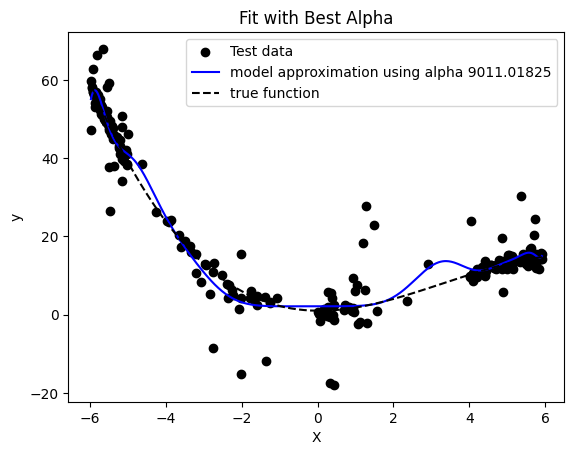

In [ ]:
alphas_cross, losses_cross, best_alpha_cross, min_loss_cross = test_alphas(verbose=True)

# initialize model with the alpha that returned the lowest average loss
model_cross = make_pipeline(poly_features, Ridge(best_alpha_cross, solver='svd'))
model_cross.fit(X, y)

# generate a dense set of X values for smooth plotting
X_dense = np.linspace(X.min(), X.max(), 500)[:, np.newaxis]
y_pred_cross = model_cross.predict(X_dense)

# plot
plt.figure()
plt.scatter(X, y, color='black', label='Test data')
plt.plot(X_dense, y_pred_cross, color='blue', label=f'model approximation using alpha {best_alpha_cross:.5f}')
plt.plot(X_dense, f(X_dense), color='black', linestyle='--', label='true function')
plt.title('Fit with Best Alpha')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

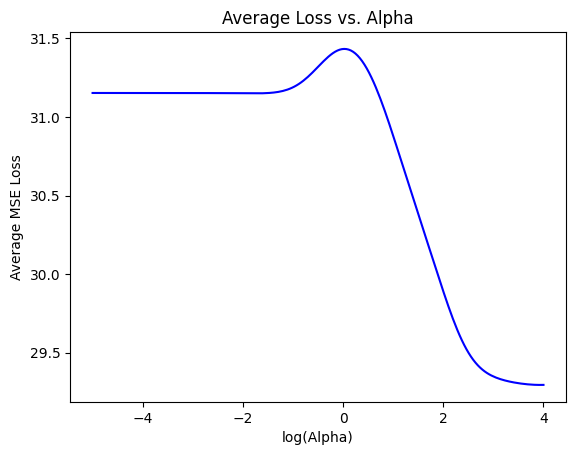

In [ ]:
# plot all the alphas and their average losses
plt.figure()
plt.plot(np.log10(alphas_cross), losses_cross, color='blue')
plt.xlabel('log(Alpha)')
plt.ylabel('Average MSE Loss')
plt.title('Average Loss vs. Alpha')
plt.show()

c) We want to compare k-fold cross validation to a validation, where the data is only split once into one train and one test set and trained once on the train set, before it is evaluated once on the test set. Complete the function implementing the training of the model, where the data is only split into one train and one test set

In [ ]:
def train_test_split_validation(X, y, model):
  """
  Performs validation on the model using one test and one train set
  @param X: Data x-values
  @param y: Data true Labels
  @param model: Model to train
  @return: mse score from testing
  """

  # TODO: split the data into test and training data
  indices = np.arange(len(X))
  np.random.shuffle(indices)

  test_indices = indices[:int(0.3 * len(X))]
  train_indices = indices[int(0.3 * len(X)):]

  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]

  # TODO: train the model on the training data
  model.fit(X_train, y_train)

  # TODO: use the trained model to make predictions on the test data
  y_pred = model.predict(X_test)

  # TODO: calculate the mse loss of the predictions on the test data
  score = mean_squared_error(y_pred, y_test)

  # TODO: return the loss
  return score

alpha: 1e-05, mse loss: 30.864463736570148
alpha: 1.1097524964120721e-05, mse loss: 31.92150529297769
alpha: 1.231550603292826e-05, mse loss: 39.77144261405118
alpha: 1.3667163564620073e-05, mse loss: 54.66212859103953
alpha: 1.516716888470924e-05, mse loss: 45.42727568642042
alpha: 1.6831803533309584e-05, mse loss: 28.724457599674437
alpha: 1.867913599020781e-05, mse loss: 24.385071519738965
alpha: 2.0729217795953697e-05, mse loss: 42.177196325459356
alpha: 2.3004301197729168e-05, mse loss: 19.981582859406682
alpha: 2.5529080682395165e-05, mse loss: 342.0456237283561
alpha: 2.833096101839324e-05, mse loss: 35.89472634527071
alpha: 3.1440354715915004e-05, mse loss: 26.60472305145728
alpha: 3.489101213406774e-05, mse loss: 37.05321392619052
alpha: 3.872038781812557e-05, mse loss: 20.174415699248755
alpha: 4.297004704320844e-05, mse loss: 33.41282570271989
alpha: 4.7686116977144744e-05, mse loss: 37.272918519054826
alpha: 5.2919787359584364e-05, mse loss: 31.377270466995448
alpha: 5.8727

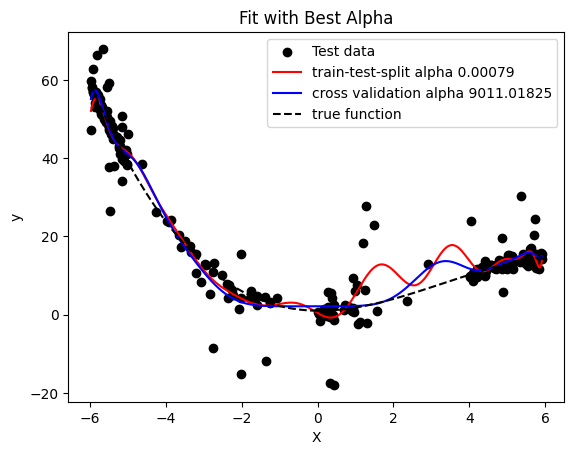

In [ ]:
alphas_split, losses_split, best_alpha_split, min_loss_split = test_alphas(cross_validation=False, verbose=True)

# initialize model with the alpha that returned the lowest average loss
model_split = make_pipeline(poly_features, Ridge(best_alpha_split, solver='svd'))
model_split.fit(X, y)

#print("------------------------------------------------------------")
#print(f"Train-test-split weights: \n{model_split['ridge'].coef_}")
#print(f"Cross validation weights: \n{model_cross['ridge'].coef_}")

# Generate a dense set of X values for smooth plotting
X_dense = np.linspace(X.min(), X.max(), 500)[:, np.newaxis]
y_pred_split = model_split.predict(X_dense)

plt.figure()
plt.scatter(X, y, color='black', label='Test data')
plt.plot(X_dense, y_pred_split, color='red', label=f'train-test-split alpha {best_alpha_split:.5f}')
plt.plot(X_dense, y_pred_cross, color='blue', label=f'cross validation alpha {best_alpha_cross:.5f}')
plt.plot(X_dense, f(X_dense), color='black', linestyle='--', label='true function')
plt.title('Fit with Best Alpha')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

d) Compare the performance of the model using the alpha optimized with cross validation and with the model using the alpha optimized with one train-test-split. For this use the Test data (holdout data) stored in the variables `X_holdout`, `y_holdout`. This data was never used before for testing in this task.

In [ ]:
# TODO: calculate mse error on holdout data for both models
y_pred_cross_holdout = model_cross.predict(X_holdout)
y_pred_split_holdout = model_split.predict(X_holdout)

loss_cross = mean_squared_error(y_pred_cross_holdout, y_holdout)
loss_split = mean_squared_error(y_pred_split_holdout, y_holdout)

print(f"loss on holdout data from cross validation = {loss_cross}, with alpha = {best_alpha_cross}")
print(f"loss on holdout data from train-test-split validation = {loss_split}, with alpha = {best_alpha_split}")

loss on holdout data from cross validation = 5.626718444309673, with alpha = 9011.018251665037
loss on holdout data from train-test-split validation = 14.304660446562924, with alpha = 0.0007934096665797492


# Task 2: Maximum Likelihood Estimation

In [ ]:
import scipy

In [ ]:
def gaussian_pdf(X, mu, sigma):

  #mu = np.mean(X)
  #sigma = np.sqrt(np.std(X))
  return 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [ ]:
def y1(X, tau):
   return 1 / np.sqrt(np.pi) * tau * np.exp(-tau * X**2)

In [ ]:
def y2(X, tau):
  y = np.zeros(X.shape)
  for i in range(X.shape[0]):
    if x[i] >= tau:
      y[i] = 1 /np.exp(x[i] - tau)
  return y

In [ ]:
def y3(X, tau):
  if np.allclose(tau, 0):
    tau = 0
  return (np.exp(-tau) * tau**X) / scipy.special.factorial(X)

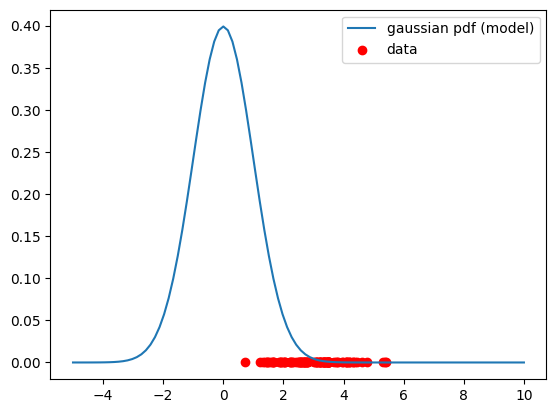

In [ ]:
x = np.linspace(-5, 10, 100)

x_data = np.random.normal(3, 1, 100)

plt.figure()
plt.plot(x, gaussian_pdf(x, 0, 1), label='gaussian pdf (model)')
plt.scatter(x_data, np.zeros(x_data.shape), color='red', label='data')
plt.legend()
plt.show()

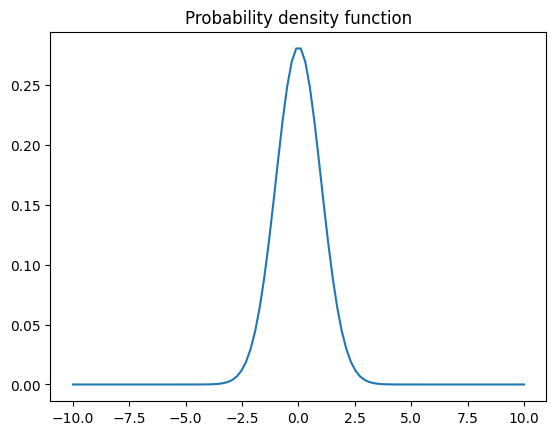

In [ ]:
# a)

tau = 0.5
x = np.linspace(-10, 10, 100)

plt.figure()
plt.title('Probability density function')
plt.plot(x, y1(x, tau), label='pdf')
plt.show()

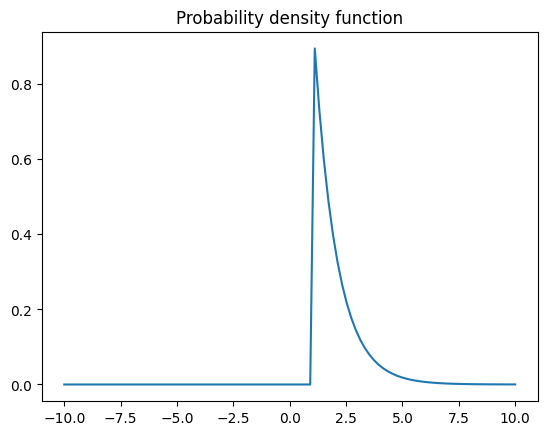

In [ ]:
# b)
tau = 1

x = np.linspace(-10, 10, 100)

plt.figure()
plt.title('Probability density function')
plt.plot(x, y2(x, tau), label='pdf')
plt.show()

[0 2 2 2 0 1 0 0 2 1 0 0 0 1 1 0 2 1 3 1 0 0 0 2 0 2 0 1 1 3 0 1 0 2 4 2 0
 0 5 0 1 0 1 1 1 2 0 0 2 0]


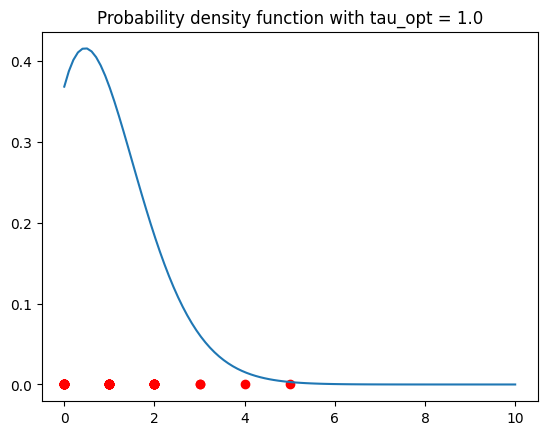

In [ ]:
# c)

tau_true = 1

x = np.linspace(0, 10, 100)

x_data = np.random.poisson(tau_true, 50)
print(x_data)
tau_opt = np.mean(x_data)

plt.figure()
plt.title(f'Probability density function with tau_opt = {tau_opt}')
plt.plot(x, y3(x, tau_opt), label='pdf')
plt.scatter(x_data, np.zeros(x_data.shape), color='red', label='data')
plt.show()